<font size="3">Importing Required Libraries:

In this section, we import the necessary libraries for data handling, visualization, preprocessing, and building the deep learning model.</font>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix , classification_report , accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense , Conv2D , MaxPool2D , Dropout , Flatten  , GlobalAveragePooling2D
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import MobileNetV2

<font size=3>Loading and Exploring the Dataset

We load the dataset and check its structure, including image dimensions and labels. This helps us understand what kind of data we are working with.</font>

In [7]:
train_generator = ImageDataGenerator(
    rescale = 1.0 / 255.0 ,
    shear_range = 0.1 , 
    zoom_range = 0.2,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True
)
test_generator = ImageDataGenerator(
    rescale = 1.0 / 255.0 ,
)

In [8]:
train_data = train_generator.flow_from_directory('chest_xray/chest_xray/train' ,
 class_mode='binary' ,
  color_mode='grayscale' , 
  batch_size=40 , 
  target_size=(224 , 224)
)
test_data = train_generator.flow_from_directory('chest_xray/chest_xray/test' ,
 class_mode='binary' ,
  color_mode='grayscale' ,
   batch_size=40 ,
   target_size=(224 , 224),
   shuffle = False
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [14]:
print(f"train data shape: {np.shape(train_data.classes)}")
print(f"test data shape: {np.shape(test_data.classes)}")

train data shape: (5216,)
test data shape: (624,)


<font size=3>Sequence Model</font>

In [15]:
model = Sequential([
    Conv2D(32 , 3 , activation='relu' , input_shape=(224,224 ,1)),
    MaxPool2D(pool_size=2 , strides=2) , 
    Conv2D(64 , 3 , activation='relu'),
    MaxPool2D(2 , 2),
    Conv2D(128 , 3 , activation='relu'),
    MaxPool2D(pool_size=2 , strides=2),
    Dropout(0.2),
    Conv2D(256 , 3 , activation='relu'),
    MaxPool2D(2 , 2),
    Dropout(0.3),
    Flatten(),
    Dense(128 , activation='relu'),
    Dense(1 , activation='sigmoid')
])

<font size=3>compile model</font>

In [16]:
model.compile(optimizer=Adam(learning_rate=0.001) , loss='binary_crossentropy', metrics=['accuracy' , 'Precision', 'Recall'])

<font size=3>imbalance data</font>

In [17]:
np.unique(train_data.classes , return_counts=True)

(array([0, 1]), array([1341, 3875], dtype=int64))

<font size=3>balance of classes</font>

In [18]:
class_weights = compute_class_weight(class_weight='balanced' , classes=np.unique(train_data.classes) , y=train_data.classes)
class_weights

array([1.9448173 , 0.67303226])

In [19]:
weights = dict(zip(np.unique(train_data.classes) , class_weights))
weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

<font size = 3>### Callbacks in Model Training

In deep learning, callbacks are a way to customize the training process by monitoring and taking actions based on the performance during training. Below are the callbacks used in this model:

#### 1. Early Stopping
This callback monitors the validation loss and stops training if the loss does not improve after a specified number of epochs (patience). It helps to avoid overfitting by preventing unnecessary training when the model has reached its best performance.

`python
early_stop = EarlyStopping(monitor='val_loss', patience=50, mode='min')

monitor='val_loss': Monitors the validation loss during training.

patience=4: Stops training if no improvement in validation loss after 50 epochs.

mode='min': The training will stop when the monitored value (validation loss) has stopped decreasing.


2. Reduce Learning Rate on Plateau

This callback reduces the learning rate by a specified factor if the validation loss plateaus for a certain number of epochs. It helps to fine-tune the model's performance after initial improvements.

rlop = ReduceLROnPlateau(monitor='val_loss', patience=50, factor=0.2, min_lr=0.001)

monitor='val_loss': Monitors the validation loss to detect when to reduce the learning rate.

patience=3: Number of epochs with no improvement before reducing the learning rate.

factor=0.5: The factor by which the learning rate will be reduced.

min_lr=0.001: The lower bound for the learning rate.


3. Model Checkpoint

This callback saves the best model based on the lowest validation loss during training, ensuring that the best performing model is retained.

check_point = ModelCheckpoint('best_xray_model.h5', monitor='val_loss', mode='min', save_best_only=True)

monitor='val_loss': Saves the model with the lowest validation loss.

mode='min': Monitors when the validation loss is minimized.

save_best_only=True: Saves only the best model (with the lowest validation loss).


Final Integration in Training

These callbacks are then passed into the model.fit() method, ensuring they are used during training:

history = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[early_stop, rlop, check_point])

Using these callbacks, the training process is optimized, ensuring the model's best performance while avoiding overfitting and unnecessary training </font>

In [20]:
early_stop = EarlyStopping(monitor='val_loss' , patience=4 , mode='min' )
rlop = ReduceLROnPlateau(monitor='val_loss' , patience=3 , factor=0.5 , min_lr=0.001)
check_point =  ModelCheckpoint('sequential_model.h5' , monitor='val_loss' , model='min' , save_best_only=True)

<font size = "3">fiting the model</font>

In [21]:
history = model.fit(train_data  , validation_data=test_data , callbacks=[early_stop , check_point , rlop] , class_weight=weights , epochs=20)

Epoch 1/20
131/131 [==============================] - 126s 951ms/step - loss: 0.5439 - accuracy: 0.7134 - precision: 0.8637 - recall: 0.7293 - val_loss: 0.5116 - val_accuracy: 0.7500 - val_precision: 0.7285 - val_recall: 0.9564 - lr: 0.0010
Epoch 2/20


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 125s 955ms/step - loss: 0.3602 - accuracy: 0.8324 - precision: 0.9635 - recall: 0.8049 - val_loss: 0.3486 - val_accuracy: 0.8462 - val_precision: 0.9200 - val_recall: 0.8256 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 118s 899ms/step - loss: 0.3371 - accuracy: 0.8459 - precision: 0.9615 - recall: 0.8255 - val_loss: 0.4372 - val_accuracy: 0.8141 - val_precision: 0.8806 - val_recall: 0.8128 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 117s 892ms/step - loss: 0.3229 - accuracy: 0.8484 - precision: 0.9676 - recall: 0.8235 - val_loss: 0.3859 - val_accuracy: 0.8365 - val_precision: 0.9444 - val_recall: 0.7846 - lr: 0.0010
Epoch 5/20
131/131 [==============================] - 116s 886ms/step - loss: 0.3190 - accuracy: 0.8535 - precision: 0.9704 - recall: 0.8281 - val_loss: 0.3433 - val_accuracy: 0.8622 - val_precision: 0.9086 - val_recall: 0.8667 - lr: 0.0010
Epoch 6/20
131/131 [===========================

In [26]:
model_sequential = load_model("./sequential_model.h5")

In [27]:
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5)
print(classification_report(test_data.classes , y_pred))

16/16 [==============================] - 4s 264ms/step
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       234
           1       0.90      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.89      0.89       624
weighted avg       0.90      0.90      0.90       624



Text(0.5, 1.0, 'Accuracy Score: 0.9006410256410257')

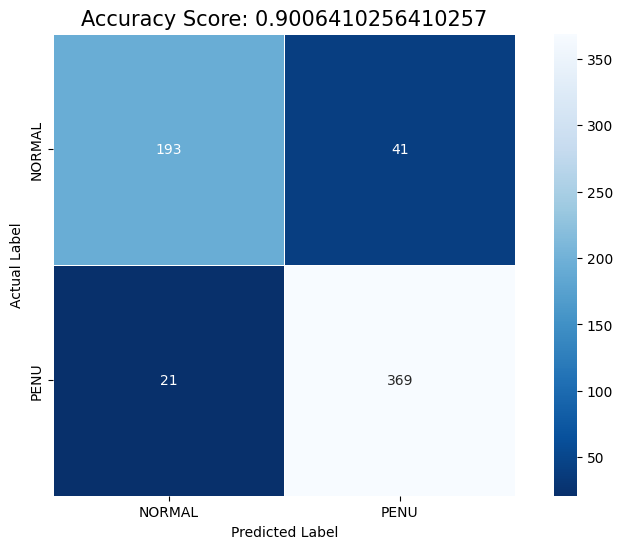

In [28]:
cm = confusion_matrix(test_data.classes, y_pred)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r' , xticklabels=["NORMAL" , "PENU"] , yticklabels=["NORMAL" , "PENU"] )
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(test_data.classes, y_pred))
plt.title(all_sample_title, size = 15)

<font size = "3">train loss and validation loss</font>


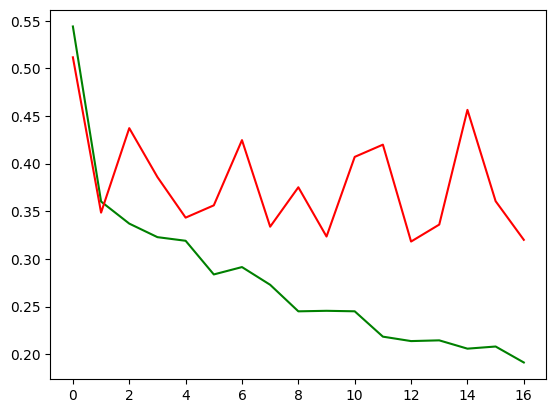

In [ ]:
plt.plot(history.history['loss'] , color='green' , label = "train_loss")
plt.plot(history.history['val_loss'] , color='red' , label = "val_loss")
plt.legend()
plt.show()

<font size = "3">train accuracy and validation accuracy</font>


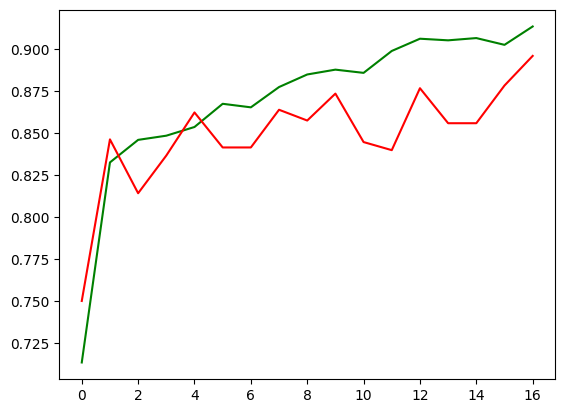

In [ ]:
plt.plot(history.history['accuracy'] , color='green' , label = "train_accuracy")
plt.plot(history.history['val_accuracy'] , color='red' , label = "val_accuracy")
plt.legend()
plt.show()

In [32]:
train_data = train_generator.flow_from_directory('chest_xray/chest_xray/train' ,
 class_mode='binary' ,
  color_mode='rgb' , 
  batch_size=40 , 
  target_size=(224 , 224)
)
test_data = train_generator.flow_from_directory('chest_xray/chest_xray/test' ,
 class_mode='binary' ,
  color_mode='rgb' ,
   batch_size=40 ,
   target_size=(224 , 224),
   shuffle = False
)


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [34]:
early_stop = EarlyStopping(monitor='val_loss' , patience=4 , mode='min' )
rlop = ReduceLROnPlateau(monitor='val_loss' , patience=3 , factor=0.5 , min_lr=0.001)
check_point =  ModelCheckpoint('Mobilenetv2_model.h5' , monitor='val_loss' , model='min' , save_best_only=True)

In [35]:
model_mobilenet = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
model_mobilenet.trainable = False
model_mobilenet.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_3[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[

In [ ]:
model = Sequential()
model.add(model_mobilenet)
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

history = model.fit(train_data  , epochs=20, validation_data=test_data, callbacks=[early_stop , rlop , check_point] , class_weight=weights)

Epoch 1/20
131/131 [==============================] - 99s 742ms/step - loss: 0.2582 - accuracy: 0.8846 - precision: 0.9661 - recall: 0.8754 - val_loss: 0.2999 - val_accuracy: 0.8718 - val_precision: 0.8673 - val_recall: 0.9385 - lr: 0.0010
Epoch 2/20


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


131/131 [==============================] - 92s 703ms/step - loss: 0.1947 - accuracy: 0.9193 - precision: 0.9758 - recall: 0.9141 - val_loss: 0.5718 - val_accuracy: 0.7901 - val_precision: 0.7534 - val_recall: 0.9872 - lr: 0.0010
Epoch 3/20
131/131 [==============================] - 92s 702ms/step - loss: 0.1924 - accuracy: 0.9174 - precision: 0.9767 - recall: 0.9105 - val_loss: 0.4129 - val_accuracy: 0.8349 - val_precision: 0.8154 - val_recall: 0.9513 - lr: 0.0010
Epoch 4/20
131/131 [==============================] - 93s 706ms/step - loss: 0.1730 - accuracy: 0.9250 - precision: 0.9778 - recall: 0.9200 - val_loss: 0.3001 - val_accuracy: 0.8718 - val_precision: 0.8875 - val_recall: 0.9103 - lr: 0.0010
Epoch 5/20
131/131 [==============================] - 92s 704ms/step - loss: 0.1711 - accuracy: 0.9289 - precision: 0.9805 - recall: 0.9226 - val_loss: 0.2728 - val_accuracy: 0.8830 - val_precision: 0.9096 - val_recall: 0.9026 - lr: 0.0010
Epoch 6/20
131/131 [==============================]

In [38]:
model = load_model("./mobilenetv2_model.h5")

In [39]:
y_pred = model.predict(test_data)
y_pred = (y_pred > 0.5)
print(classification_report(test_data.classes , y_pred))

16/16 [==============================] - 10s 577ms/step
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       234
           1       0.89      0.91      0.90       390

    accuracy                           0.87       624
   macro avg       0.87      0.86      0.86       624
weighted avg       0.87      0.87      0.87       624



Text(0.5, 1.0, 'Accuracy Score: 0.8733974358974359')

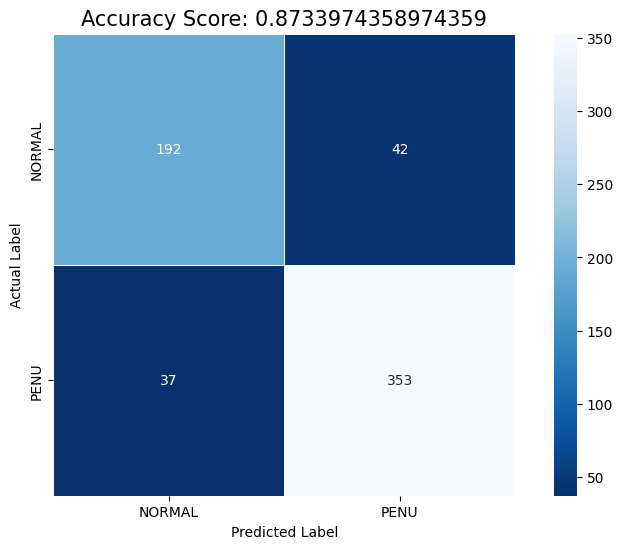

In [40]:
cm = confusion_matrix(test_data.classes, y_pred)
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'Blues_r' , xticklabels=["NORMAL" , "PENU"] , yticklabels=["NORMAL" , "PENU"] )
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
all_sample_title = 'Accuracy Score: {0}'.format(accuracy_score(test_data.classes, y_pred))
plt.title(all_sample_title, size = 15)

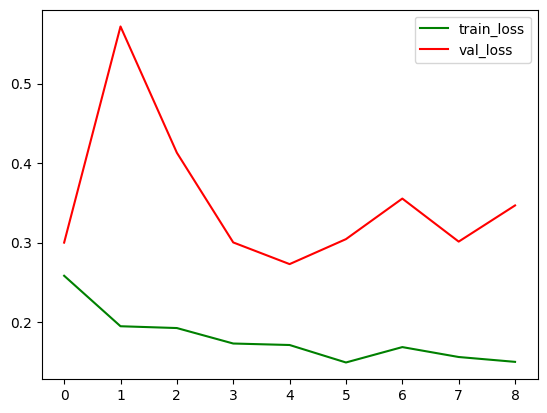

In [44]:
plt.plot(history.history['loss'] , color='green' , label="train_loss")
plt.plot(history.history['val_loss'] , color='red' , label = "val_loss")
plt.legend()
plt.show()

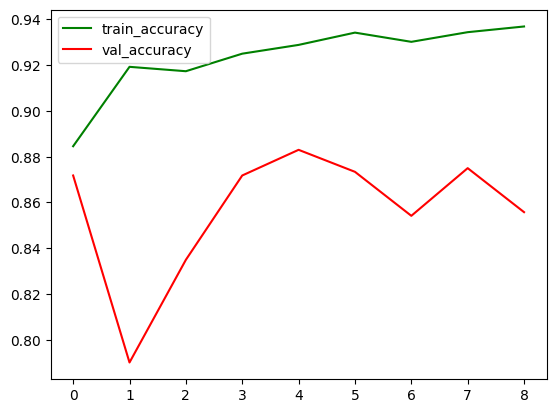

In [45]:
plt.plot(history.history['accuracy'] , color='green' , label = "train_accuracy")
plt.plot(history.history['val_accuracy'] , color='red' , label = "val_accuracy")
plt.legend()
plt.show()

In [98]:
person1 = image.load_img('NORMAL2-IM-0347-0001.jpeg' , target_size=(224,224) , color_mode='rgb')

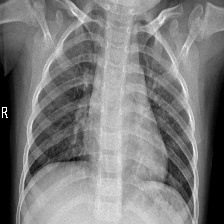

In [99]:
person1

In [100]:
person1 = img_to_array(person1) / 255.0

In [101]:
np.shape(person1)

(224, 224, 3)

In [102]:
person1 = np.expand_dims(person1 , axis=0)
person1

array([[[[0.2       , 0.2       , 0.2       ],
         [0.20392157, 0.20392157, 0.20392157],
         [0.22352941, 0.22352941, 0.22352941],
         ...,
         [0.30980393, 0.30980393, 0.30980393],
         [0.31764707, 0.31764707, 0.31764707],
         [0.3019608 , 0.3019608 , 0.3019608 ]],

        [[0.2       , 0.2       , 0.2       ],
         [0.22745098, 0.22745098, 0.22745098],
         [0.21568628, 0.21568628, 0.21568628],
         ...,
         [0.32156864, 0.32156864, 0.32156864],
         [0.32941177, 0.32941177, 0.32941177],
         [0.32156864, 0.32156864, 0.32156864]],

        [[0.2       , 0.2       , 0.2       ],
         [0.20784314, 0.20784314, 0.20784314],
         [0.23137255, 0.23137255, 0.23137255],
         ...,
         [0.34117648, 0.34117648, 0.34117648],
         [0.33333334, 0.33333334, 0.33333334],
         [0.32156864, 0.32156864, 0.32156864]],

        ...,

        [[0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        ]

In [103]:
np.shape(person1)

(1, 224, 224, 3)

In [104]:
y_pred_person1 = model.predict(person1)
if y_pred_person1 > 0.7 :
    print(f'PNEUMONIA with probability : {y_pred_person1[0][0]}')
else :
    print(f'NORMAL with probability : {y_pred_person1[0][0]}')

1/1 [==============================] - 0s 425ms/step
NORMAL with probability : 0.018144750967621803


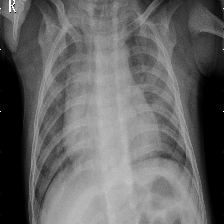

In [105]:
person2 = image.load_img('person1650_virus_2854.jpeg' , target_size=(224,224) , color_mode='rgb')
person2

In [106]:
person2 = img_to_array(person2) / 255.0
person2 = np.expand_dims(person2 , axis=0)
y_pred_person2 = model.predict(person2)
if y_pred_person2 > 0.7:
    print(f'PNEUMONIA with probability : {y_pred_person2[0][0]}')
else:
    print(f'NORMAL with probability : {y_pred_person2[0][0]}')

1/1 [==============================] - 0s 31ms/step
PNEUMONIA with probability : 0.7011715173721313


<font size=5>predict X_ray images</font>

In [ ]:
def image_prediction_with_model_Sequential(img_path):
    img = image.load_img(img_path, target_size=(224, 224), color_mode='grayscale')
    plt.imshow(img , cmap="gray")
    img_array = img_to_array(img) / 255.0
    person = np.expand_dims(img_array, axis=0)
    y_pred = model.predict(person)

    if y_pred[0][0] > 0.7:
        print(f'PNEUMONIA with probability: {y_pred[0][0]}')
    else:
        print(f'NORMAL with probability: {y_pred[0][0]}')

1/1 [==============================] - 0s 40ms/step
NORMAL with probability: 0.3280249238014221


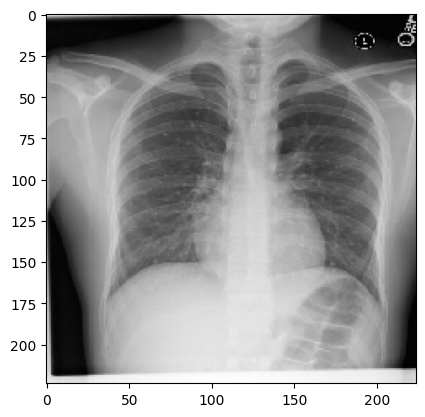

In [51]:
image_prediction_with_model_Sequential("./debc366fbee881069b1bd4b23a8020_big_gallery.jpg")

1/1 [==============================] - 0s 26ms/step
PNEUMONIA with probability: 0.9950491189956665


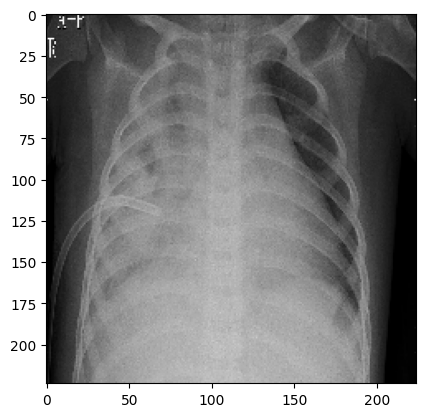

In [56]:
image_prediction_with_model_Sequential("./person1938_bacteria_4854.jpeg")

1/1 [==============================] - 0s 31ms/step
NORMAL with probability: 0.0381128191947937


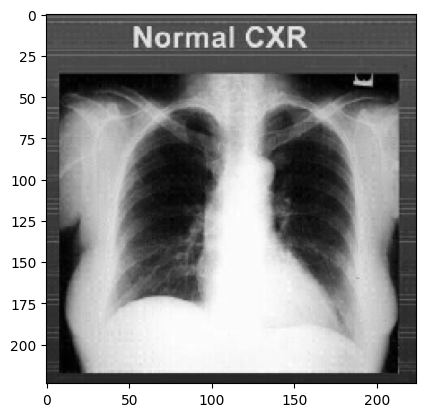

In [57]:
image_prediction_with_model_Sequential("./1.jpg")

1/1 [==============================] - 0s 31ms/step
NORMAL with probability: 0.011695285327732563


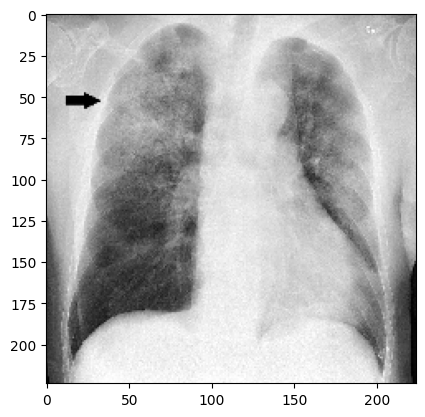

In [58]:
image_prediction_with_model_Sequential("./1024px-Chest_radiograph_in_influensa_and_H_influenzae,_posteroanterior,_annotated.jpg")

1/1 [==============================] - 0s 34ms/step
NORMAL with probability: 0.09612201899290085


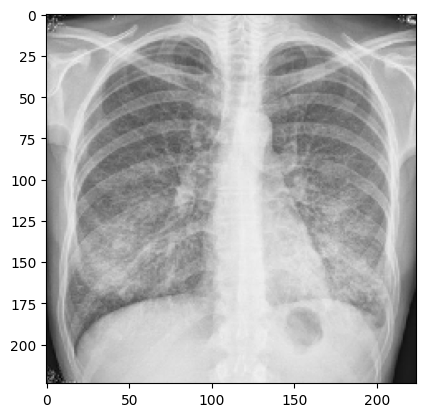

In [59]:
image_prediction_with_model_Sequential("./319c43fb5c1c2fca2a4e710a7a6c4a_big_gallery.jpg")

1/1 [==============================] - 0s 22ms/step
NORMAL with probability: 0.36276644468307495


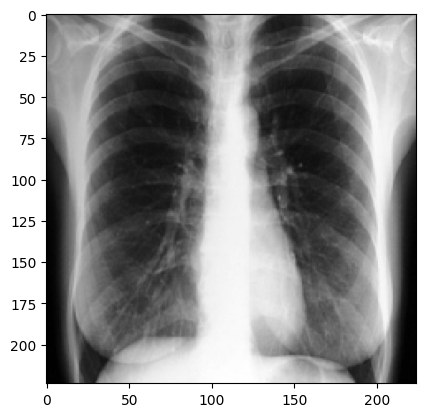

In [62]:
image_prediction_with_model_Sequential("./600600p579EDNmaincache_993844-497x423.jpg")

1/1 [==============================] - 0s 34ms/step
NORMAL with probability: 0.3280249238014221


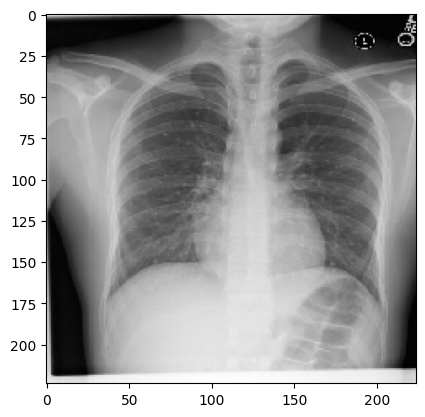

In [63]:
image_prediction_with_model_Sequential("./debc366fbee881069b1bd4b23a8020_big_gallery.jpg")

1/1 [==============================] - 0s 24ms/step
NORMAL with probability: 0.3595064580440521


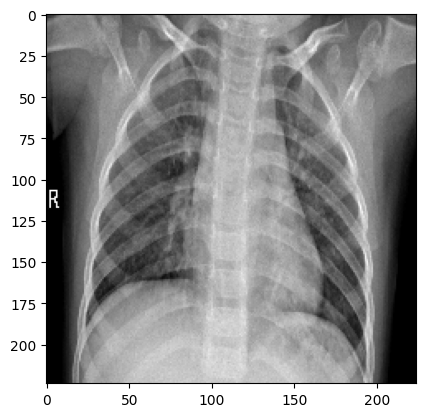

In [64]:
image_prediction_with_model_Sequential("./NORMAL2-IM-0347-0001.jpeg")

1/1 [==============================] - 0s 25ms/step
NORMAL with probability: 0.12502391636371613


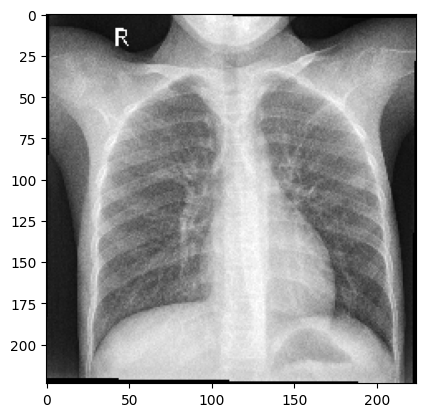

In [65]:
image_prediction_with_model_Sequential("./NORMAL2-IM-0941-0001.jpeg")

1/1 [==============================] - 0s 36ms/step
PNEUMONIA with probability: 0.9932116270065308


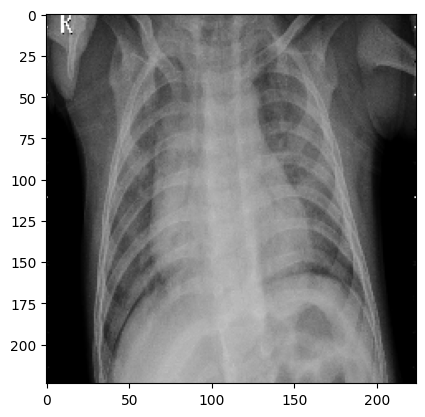

In [66]:
image_prediction_with_model_Sequential("./person1650_virus_2854.jpeg")

1/1 [==============================] - 0s 30ms/step
PNEUMONIA with probability: 0.9950491189956665


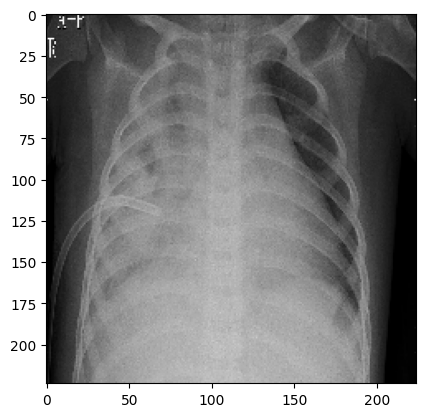

In [67]:
image_prediction_with_model_Sequential("./person1938_bacteria_4854.jpeg")

1/1 [==============================] - 0s 36ms/step
PNEUMONIA with probability: 0.9997128844261169


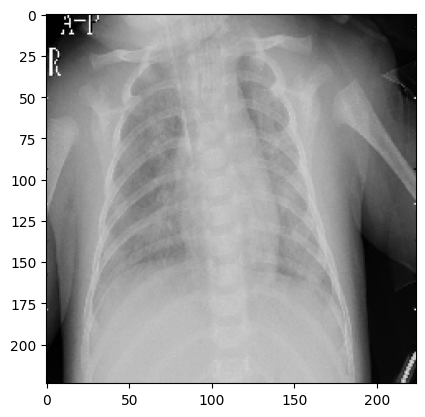

In [68]:
image_prediction_with_model_Sequential("./person1951_bacteria_4882.jpeg")

1/1 [==============================] - 0s 36ms/step
NORMAL with probability: 0.11054148524999619


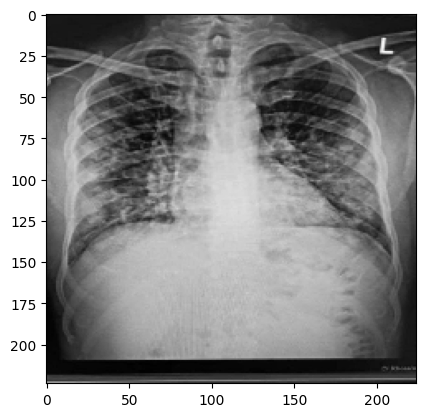

In [69]:
image_prediction_with_model_Sequential("./photo_2025-03-30_00-35-03.jpg")

1/1 [==============================] - 0s 35ms/step
NORMAL with probability: 0.0405559316277504


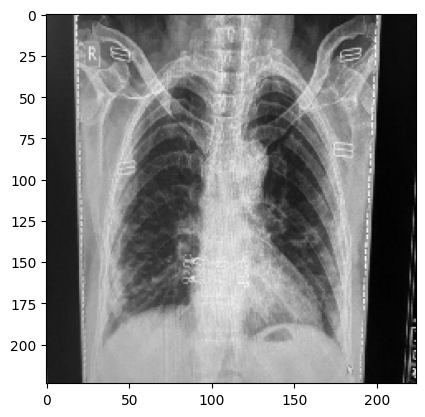

In [70]:
image_prediction_with_model_Sequential("./photo_2025-03-30_00-35-04 (2).jpg")

1/1 [==============================] - 0s 31ms/step
PNEUMONIA with probability: 0.8069493174552917


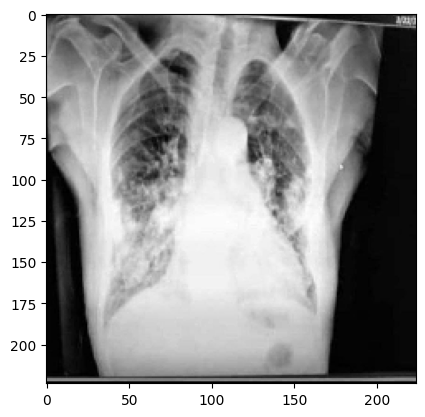

In [71]:
image_prediction_with_model_Sequential("./photo_2025-03-30_00-35-04.jpg")

In [5]:
model = load_model("./sequential_model.h5")

In [9]:
pred = model.predict(test_data)
pred_labels = np.argmax(pred, axis=1)
true_labels = test_data.classes
class_names = list(test_data.class_indices.keys())
y_true = test_data.classes

16/16 [==============================] - 5s 306ms/step


In [14]:
class_names

['NORMAL', 'PNEUMONIA']

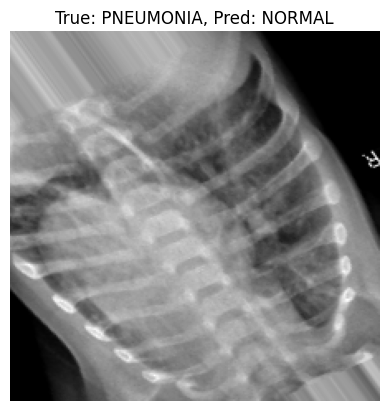

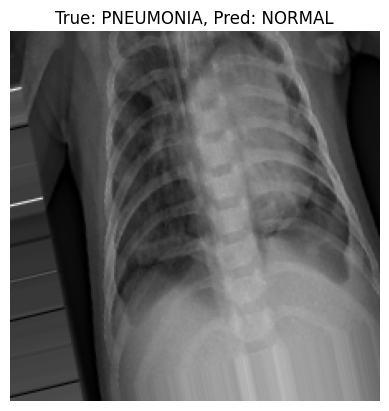

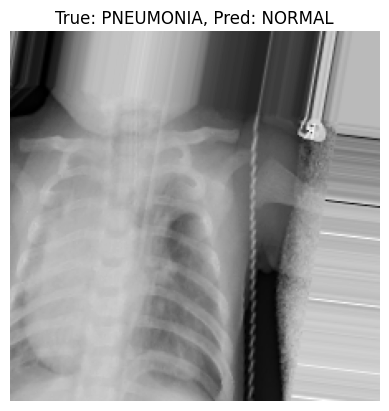

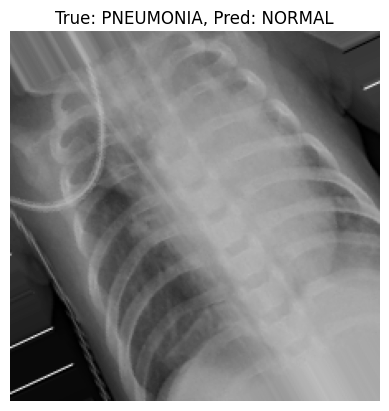

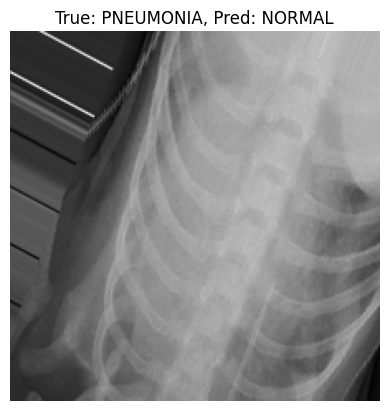

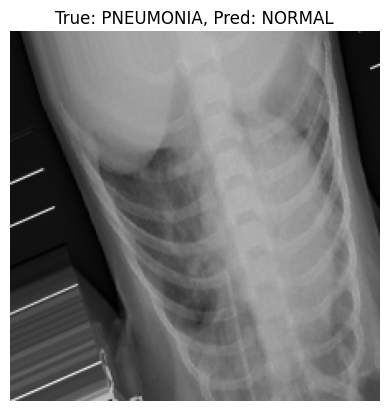

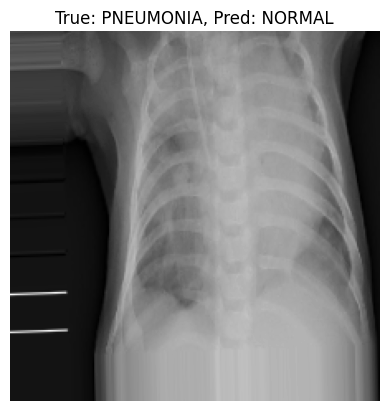

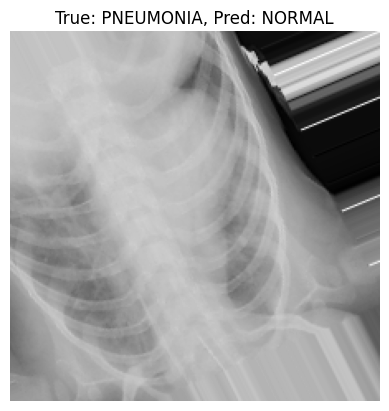

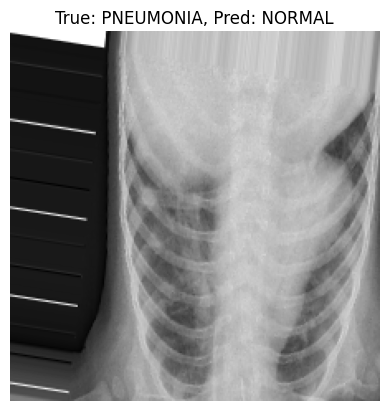

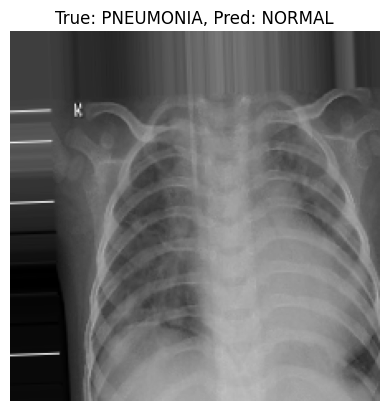

In [ ]:
wrong_idx = np.where(pred_labels != y_true)[0]
import cv2

for i in range(10):
    idx = wrong_idx[i]

    batch_idx = idx // test_data.batch_size
    image_idx = idx % test_data.batch_size

    batch = test_data[batch_idx]  
    img = batch[0][image_idx]  
    true_label = y_true[idx]
    pred_label = pred_labels[idx]
    plt.imshow(img , cmap='gray')
    plt.title(f"True: {class_names[true_label]}, Pred: {class_names[pred_label]}")
    plt.axis('off')
    plt.show()